<a href="https://colab.research.google.com/github/codeyumm/adl5500-yelp-sentiment-analysis/blob/main/ADL_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
import string
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# path to dataset in google drive
%cd /content/drive/MyDrive/Sem 2/Advanced Deep Learning - AIGC-5500-0NA/Final Project/

/content/drive/MyDrive/Sem 2/Advanced Deep Learning - AIGC-5500-0NA/Final Project


In [ ]:
# get the dataset
df = pd.read_csv("./extracted_reviews.csv")

### Exploratory Data Analysis

In [ ]:
# peek at the first few rows
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
3,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
4,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31


### From all the cols, stars and text are the most important for sentiment analysis so we will focus on those two cols only

In [ ]:
df_prev = df

df = df[["stars", "text"]]

In [ ]:
df.head()

,stars,text
0,3.0,"If you decide to eat here, just be aware it is..."
1,3.0,Family diner. Had the buffet. Eclectic assortm...
2,5.0,"Wow! Yummy, different, delicious. Our favo..."
3,4.0,Cute interior and owner (?) gave us tour of up...
4,1.0,I am a long term frequent customer of this est...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   stars   60000 non-null  float64
 1   text    60000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 937.6+ KB


### Checking for null values


In [ ]:
df.isna().sum()

,0
stars,0
text,0


### We don't have any null values.

-
### Checking for duplicated records.

In [ ]:
df.duplicated().sum()

np.int64(28)

### We can remove 16 records which are duplicated from total 50,000 records.

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

_

_

_

### For sentiment analysis, we'll map star ratings as follows:
### 1-2 stars → Negative, 3 stars → Neutral, 4-5 stars → Positive

In [ ]:
# to convert star to negative, neutral and positive
def convert_to_sentiment(star):
  if star <= 2:
    return 'negative'
  elif star == 3:
    return 'neutral'
  else: # star 4 or 5
    return 'positive'

In [ ]:
df['sentiment'] = df['stars'].apply(convert_to_sentiment)

In [ ]:
df.head()

,stars,text,sentiment
0,3.0,"If you decide to eat here, just be aware it is...",neutral
1,3.0,Family diner. Had the buffet. Eclectic assortm...,neutral
2,5.0,"Wow! Yummy, different, delicious. Our favo...",positive
3,4.0,Cute interior and owner (?) gave us tour of up...,positive
4,1.0,I am a long term frequent customer of this est...,negative


> Checking if sentiment is balanced or not

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
positive,19996
negative,19990
neutral,19986


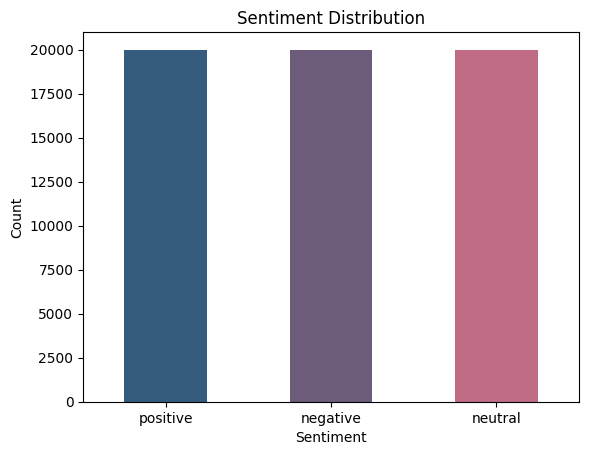

In [ ]:
sentiment_counts = df['sentiment'].value_counts()

colors = {
    'negative': '#355c7d',
    'neutral':  '#6c5b7b',
    'positive': '#c06c84'
}

sentiment_counts.plot(kind='bar', color=['#355c7d', '#6c5b7b', '#c06c84'])

plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### We can see that data is almost balanced.

### Observig length of the reviews.

In [ ]:
# adding new col which contains length of each review
df["text_length"] = df["text"].apply(len)

In [ ]:
df.head()

,stars,text,sentiment,text_length
0,3.0,"If you decide to eat here, just be aware it is...",neutral,513
1,3.0,Family diner. Had the buffet. Eclectic assortm...,neutral,339
2,5.0,"Wow! Yummy, different, delicious. Our favo...",positive,243
3,4.0,Cute interior and owner (?) gave us tour of up...,positive,534
4,1.0,I am a long term frequent customer of this est...,negative,341


In [ ]:
print("Average review length:", df['text_length'].mean())
print("Max review length:", df['text_length'].max())
print("Min review length:", df['text_length'].min())

Average review length: 608.0417694924298
Max review length: 5000
Min review length: 3


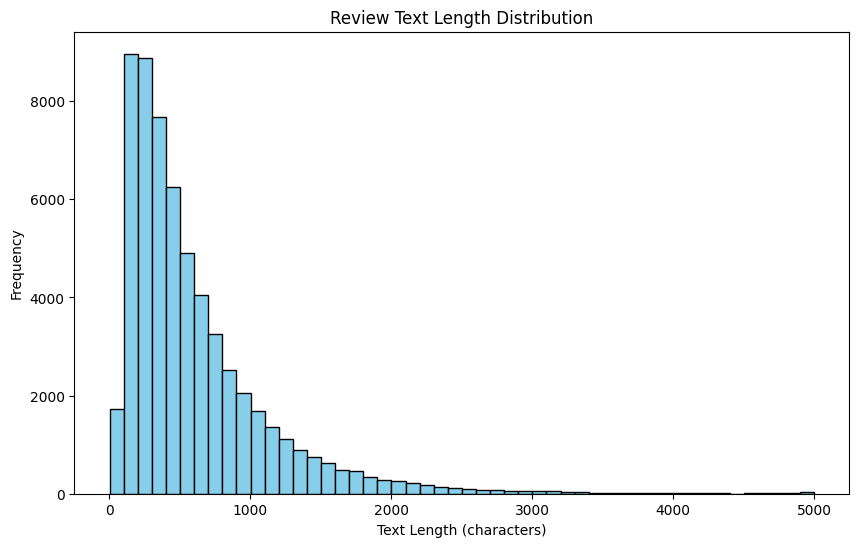

In [ ]:
# Plot histogram of review lengths
plt.figure(figsize=(10, 6))
df['text_length'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Review Text Length Distribution')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

--

### Tokenization

In [ ]:
# function for preprocessing the text

def data_preprocessing(text):
    # convert to lowercase
    text = text.lower()

    # remove punctuation
    text = ''.join(c for c in text if c not in string.punctuation)

    # tokenizing
    tokens = word_tokenize(text)
    return tokens

data_preprocessing("What's your name? my name is priyam hello how are you")

['whats',
 'your',
 'name',
 'my',
 'name',
 'is',
 'priyam',
 'hello',
 'how',
 'are',
 'you']

In [ ]:
# preprocessign each review in df
df['tokens'] = df['text'].apply(data_preprocessing)

In [ ]:
df.head()

,stars,text,sentiment,text_length,tokens
0,3.0,"If you decide to eat here, just be aware it is...",neutral,513,"[if, you, decide, to, eat, here, just, be, awa..."
1,3.0,Family diner. Had the buffet. Eclectic assortm...,neutral,339,"[family, diner, had, the, buffet, eclectic, as..."
2,5.0,"Wow! Yummy, different, delicious. Our favo...",positive,243,"[wow, yummy, different, delicious, our, favori..."
3,4.0,Cute interior and owner (?) gave us tour of up...,positive,534,"[cute, interior, and, owner, gave, us, tour, o..."
4,1.0,I am a long term frequent customer of this est...,negative,341,"[i, am, a, long, term, frequent, customer, of,..."


### Building Vocabulary

In [ ]:
# get all token in one list
all_tokens = []
for tokens in df['tokens']:
    for token in tokens:
        all_tokens.append(token)


word_freq = Counter(all_tokens)

In [ ]:
vocab = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
vocab[:10]

[('the', 366036),
 ('and', 224469),
 ('a', 174911),
 ('i', 167196),
 ('to', 153691),
 ('was', 144900),
 ('of', 97013),
 ('it', 92902),
 ('for', 80931),
 ('is', 75717)]

In [ ]:
len(vocab)

74282

### We have total 74282 words.

In [ ]:
# Keeping stop words for LSTM to preserve sentence structure and context.
word2idx = {'<PAD>': 0, '<UNK>': 1}
for idx, (word, _) in enumerate(vocab, start=2):
    word2idx[word] = idx


In [ ]:
def encode(tokens, word2idx):
    input_ids = []
    for token in tokens:
        index = word2idx.get(token, word2idx['<UNK>'])  # Use <UNK> for out-of-vocab
        input_ids.append(index)
    return input_ids

df['input_ids'] = df['tokens'].apply(lambda x: encode(x, word2idx))


In [ ]:
df.head()

,stars,text,sentiment,text_length,tokens,input_ids
0,3.0,"If you decide to eat here, just be aware it is...",neutral,513,"[if, you, decide, to, eat, here, just, be, awa...","[38, 26, 1456, 6, 126, 44, 37, 31, 2037, 9, 11..."
1,3.0,Family diner. Had the buffet. Eclectic assortm...,neutral,339,"[family, diner, had, the, buffet, eclectic, as...","[362, 851, 24, 2, 549, 2964, 3136, 4, 283, 81,..."
2,5.0,"Wow! Yummy, different, delicious. Our favo...",positive,243,"[wow, yummy, different, delicious, our, favori...","[908, 698, 250, 125, 33, 288, 11, 2, 827, 808,..."
3,4.0,Cute interior and owner (?) gave us tour of up...,positive,534,"[cute, interior, and, owner, gave, us, tour, o...","[754, 1167, 3, 519, 342, 64, 712, 8, 9278, 332..."
4,1.0,I am a long term frequent customer of this est...,negative,341,"[i, am, a, long, term, frequent, customer, of,...","[5, 192, 4, 190, 4427, 1590, 323, 8, 18, 780, ..."


In [ ]:
df['text_length'].describe()

,text_length
count,59972.000000
mean,608.041769
std,543.802169
min,3.000000
25%,250.000000
50%,442.000000
75%,778.000000
max,5000.000000


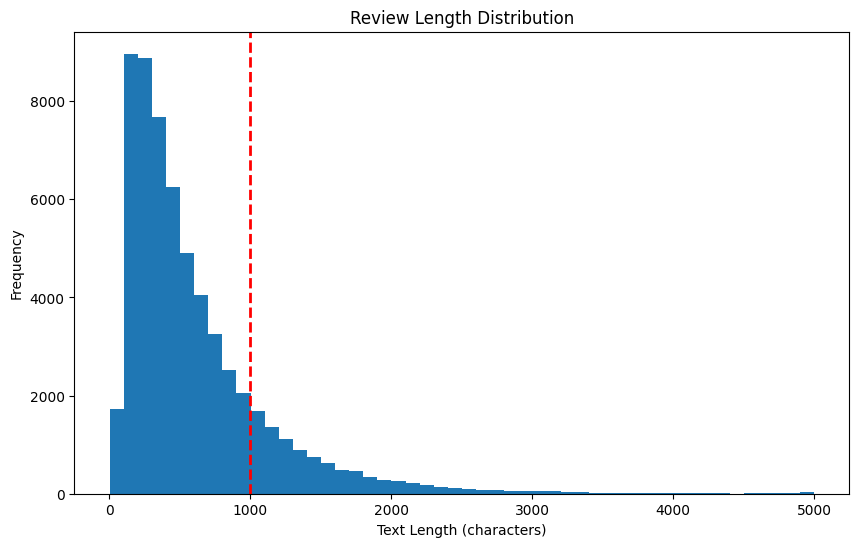

In [ ]:
df['text_length'].plot(kind='hist', bins=50, figsize=(10,6))
plt.axvline(1000, color='red', linestyle='dashed', linewidth=2)  # Visual max_len cutoff
plt.title('Review Length Distribution')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
df['token_length'] = df['tokens'].apply(len)
df['token_length'].describe()


,token_length
count,59972.000000
mean,112.119856
std,100.566290
min,1.000000
25%,46.000000
50%,82.000000
75%,144.000000
max,980.000000


### Based on length size of review we are creating three dataframes.

In [ ]:
short_df = df[df['token_length'] <= 200].copy()
medium_df = df[(df['token_length'] > 200) & (df['token_length'] <= 500)].copy()
long_df = df[(df['token_length'] > 500) & (df['token_length'] <= 1000)].copy()

In [ ]:
def pad_sequence(seq, max_len):
    # if the sequence is shorter than max_len, add <PAD> tokens at the end
    if len(seq) < max_len:
        pad_length = max_len - len(seq)
        padding = [word2idx['<PAD>']] * pad_length
        return seq + padding
    else:
      # if it's too long, cut it down to max_len
        return seq[:max_len]


short_df['padded_input_ids'] = short_df['input_ids'].apply(lambda x: pad_sequence(x, 200))
medium_df['padded_input_ids'] = medium_df['input_ids'].apply(lambda x: pad_sequence(x, 500))
long_df['padded_input_ids'] = long_df['input_ids'].apply(lambda x: pad_sequence(x, 1000))

In [ ]:
long_df.head()

,stars,text,sentiment,text_length,tokens,input_ids,token_length,padded_input_ids
152,2.0,"Too big, too expensive and too far from Downto...",negative,3237,"[too, big, too, expensive, and, too, far, from...","[82, 243, 82, 504, 3, 82, 381, 54, 722, 5, 7, ...",592,"[82, 243, 82, 504, 3, 82, 381, 54, 722, 5, 7, ..."
259,1.0,--------DINNER REVIEW----------\n\nI rarely wr...,negative,2752,"[dinner, review, i, rarely, write, reviews, bu...","[160, 324, 5, 1996, 824, 338, 14, 18, 732, 7, ...",502,"[160, 324, 5, 1996, 824, 338, 14, 18, 732, 7, ..."
351,3.0,The long and the short of it: A romantic littl...,neutral,2949,"[the, long, and, the, short, of, it, a, romant...","[2, 190, 3, 2, 581, 8, 9, 4, 2086, 94, 1368, 1...",547,"[2, 190, 3, 2, 581, 8, 9, 4, 2086, 94, 1368, 1..."
392,5.0,After a long hiatus from reviewing I have awak...,positive,3843,"[after, a, long, hiatus, from, reviewing, i, h...","[88, 4, 190, 10224, 54, 4199, 5, 27, 17042, 54...",681,"[88, 4, 190, 10224, 54, 4199, 5, 27, 17042, 54..."
397,4.0,My boyfriend and I both decided to try Jesse's...,positive,2915,"[my, boyfriend, and, i, both, decided, to, try...","[16, 673, 3, 5, 193, 301, 6, 98, 8338, 10, 2, ...",543,"[16, 673, 3, 5, 193, 301, 6, 98, 8338, 10, 2, ..."


### Converting labels to numeric values

In [ ]:
sentiment_to_idx = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['sentiment'].map(sentiment_to_idx)

In [ ]:
df.head()

,stars,text,sentiment,text_length,tokens,input_ids,token_length,label
0,3.0,"If you decide to eat here, just be aware it is...",neutral,513,"[if, you, decide, to, eat, here, just, be, awa...","[38, 26, 1456, 6, 126, 44, 37, 31, 2037, 9, 11...",101,1
1,3.0,Family diner. Had the buffet. Eclectic assortm...,neutral,339,"[family, diner, had, the, buffet, eclectic, as...","[362, 851, 24, 2, 549, 2964, 3136, 4, 283, 81,...",55,1
2,5.0,"Wow! Yummy, different, delicious. Our favo...",positive,243,"[wow, yummy, different, delicious, our, favori...","[908, 698, 250, 125, 33, 288, 11, 2, 827, 808,...",40,2
3,4.0,Cute interior and owner (?) gave us tour of up...,positive,534,"[cute, interior, and, owner, gave, us, tour, o...","[754, 1167, 3, 519, 342, 64, 712, 8, 9278, 332...",93,2
4,1.0,I am a long term frequent customer of this est...,negative,341,"[i, am, a, long, term, frequent, customer, of,...","[5, 192, 4, 190, 4427, 1590, 323, 8, 18, 780, ...",65,0


In [ ]:
df['label'].value_counts()

,count
label,
2,19996
0,19990
1,19986


# To-Do List for Tomorrow

## Done
- Data extraction and filtering
- Sentiment labeling (negative, neutral, positive)
- Text cleaning and tokenization
- Vocabulary building and encoding
- Review length categorization and padding
- Mapping sentiment to numeric labels

## To Do
1. Create PyTorch Dataset class
2. Create DataLoaders for short, medium, and long reviews
3. Build LSTM model
4. Train the model
5. Evaluate model performance (accuracy, precision, recall, F1)
6. Compare results across different review lengths

## Optional
- Add early stopping or learning rate scheduler
- Visualize important tokens or attention
- Save model checkpoints
